# Improved One Image Overview for screw-thread

Algorithm is based on draft. Purpose of this notebook:
- clean the previous notebook (move all to python files)
- select different part of raw frame for blending

In [1]:
from tqdm.auto import tqdm
from steps.image_row_stitcher import ImageRowStitcher
from steps.video_camera_motion import VideoMotion
import os
import cv2
import imageio.v3 as iio
import numpy as np
import src.pipelines.oio_building_pipeline as oio_builder
from src.config import *
from src.steps.video_frame_lightness import VideoLightness
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize

In [2]:
SRC = '/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/input'

In [3]:
videos = [file for file in os.listdir(SRC) if file.endswith("MP4") and file.startswith("GX")]

In [4]:
videos

['GX010980.MP4', 'GX010981.MP4']

In [5]:
def process_video(video):
    print(f"Processing video {video}")
    video_file_path = os.path.join(SRC, video)
    # lightness = VideoLightness(video_file_path)
    # lightness.process()
    motions = VideoMotion(video_file_path)
    motions.process()
    
    vidcap = cv2.VideoCapture(video_file_path)
    
    # print(motions.getIntervals())
    
    rows = []
    for i, interval in enumerate(motions.getIntervals()):
        mn, mx = interval
        start = mn + (mx - mn) // 2 - motions.getFramesPer360() // 2
        end = start + motions.getFramesPer360()
        file_path = video_file_path.replace(".MP4", f"-oio-{i}.png")
        if not os.path.isfile(file_path):
            row = oio_builder.construct_row(vidcap, int(start), int(end), direction=motions.getDirection(), rotation=motions.isPortrait(), shift_per_frame=motions.getHorizontalSpeed(), frames_per_360_deg=motions.getFramesPer360())
            rows.append(row)
            iio.imwrite(file_path, row.astype(np.uint8))
            
    stitcher = ImageRowStitcher(SRC, video, motions, move_down=motions.isMovingDown())
    stitcher.process()

In [6]:
for video in videos:
    process_video(video)

Processing video GX010980.MP4
Intervals: [[ 110. 2253.]
 [2504. 4645.]
 [4878. 7018.]
 [7282. 9422.]] Loaded
Horizontal speed: 10.220281862742906, Vertical shift: -1533.5089228706856, Clockwise: CCW, Portrait: False Calculated
Frames per 360: 1949.0 Loaded
Processing video GX010981.MP4
Intervals: [[  100.  2238.]
 [ 2528.  4667.]
 [ 4966.  7107.]
 [ 7422.  9561.]
 [ 9832. 11969.]] Loaded
Horizontal speed: 10.233888337641034, Vertical shift: 1545.2295722269018, Clockwise: CCW, Portrait: False Calculated
Frames per 360: 1945.0 Loaded
{'scan_shift': 1545, 'roll': -1956, 'first_frame': (1560, 1986)}


Computing positions for stitching:   0%|          | 0/4 [00:00<?, ?it/s]

Rolling image for stitching:   0%|          | 0/4 [00:00<?, ?it/s]

Stitching image:   0%|          | 0/4 [00:00<?, ?it/s]

 
## Load images

In [13]:
video = 'GX010980.MP4'

In [14]:
def crop_row(arr):
    return arr[:, np.any((arr != 0), axis=0)]

In [15]:
rows_images = []
for filename in sorted(os.listdir(SRC)):
    if video.replace(".MP4","") + "-oio-" in filename and "png" in filename:
        print(filename)
        rows_images.append(crop_row(iio.imread(os.path.join(SRC, filename))))

GX010980-oio-0.png
GX010980-oio-1.png
GX010980-oio-2.png
GX010980-oio-3.png


In [16]:
len(rows_images)

4

In [17]:
for r in rows_images:
    print(r.shape)

(2160, 19929)
(2160, 19929)
(2160, 19929)
(2160, 19929)


In [18]:
scan_shift = 1545
roll = -1956

In [19]:
rows_showed = 500
columns_showed = 1000

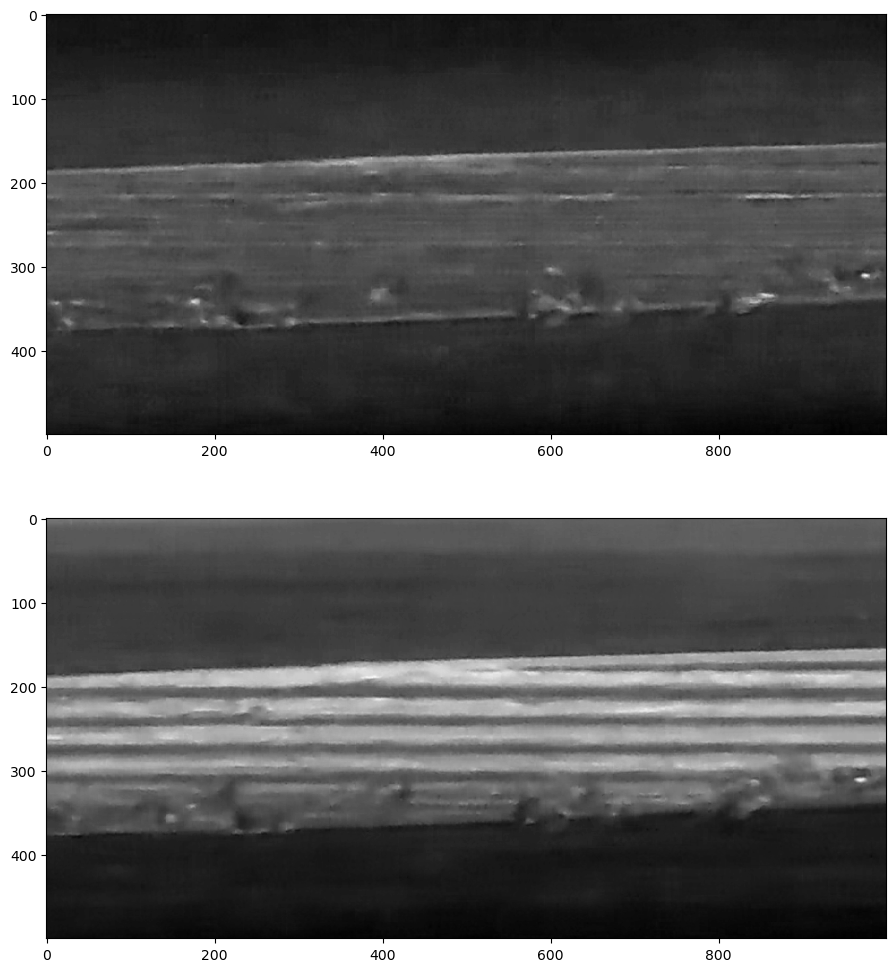

In [243]:
plt.figure(figsize=(20,12))
ax = plt.subplot(211)
ax.imshow(rows_images[4][1560:1560+rows_showed, 10000:10000+columns_showed], cmap="gray")
ax = plt.subplot(212)
ax.imshow(rows_images[3][1560-scan_shift:1560+rows_showed-scan_shift, 10000+roll:10000+columns_showed+roll], cmap="gray")
# ax = plt.subplot(211)
# ax.imshow(np.rot90(rows_images[0], 2)[1560:1560+rows_showed, 9500:9500+columns_showed], cmap="gray")
# ax = plt.subplot(212)
# ax.imshow(np.rot90(rows_images[1], 2)[1560-scan_shift:1560+rows_showed-scan_shift, 9500+roll:9500+columns_showed+roll], cmap="gray")
# ax = plt.subplot(211)
# ax.imshow(np.rot90(rows_images[1], 2), cmap="gray")
# ax = plt.subplot(212)
# ax.imshow(np.rot90(rows_images[0], 2), cmap="gray")
# ax = plt.subplot(211)
# ax.imshow(rows_images[1][1560:2160, :], cmap="gray")
# ax = plt.subplot(212)
# ax.imshow(rows_images[2][1560-shift:2160-shift, :], cmap="gray")
# ax = plt.subplot(211)
# ax.imshow(rows_images[0][:, 7500:10000], cmap="gray")
# ax = plt.subplot(212)
# ax.imshow(rows_images[1][:, 7500+roll:10000+roll], cmap="gray")
# ax = plt.subplot(513)
# ax.imshow(rows_images[2][:, 5000:7500], cmap="gray")
# ax = plt.subplot(514)
# ax.imshow(rows_images[3][:, 5000:7500], cmap="gray")
# ax = plt.subplot(515)
# ax.imshow(rows_images[4][:, 5000:7500], cmap="gray")

In [42]:
def mutual_information(imgA, imgB, bins=15):
    # taken from https://matthew-brett.github.io/teaching/mutual_information.html
    # print(imgA.shape, imgB.shape)
    hist_2d, x_edges, y_edges = np.histogram2d(
        imgA.ravel(),
        imgB.ravel(),
        bins=bins
    )
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1)  # marginal for x over y
    py = np.sum(pxy, axis=0)  # marginal for y over x
    px_py = px[:, None] * py[None, :]  # Broadcast to multiply marginals

    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0  # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def extract_images_and_compute_mi(shift, imgA, imgB, seed_position, width, height):
    # print(shift, height, width, seed_position)
    x = np.arange(seed_position[1, 0] + shift[0], seed_position[1, 0] + shift[0] + height - 0.5)
    y = np.arange(seed_position[1, 1] + shift[1], seed_position[1, 1] + shift[1] + width - 0.5)
    # print(x.shape, y.shape)
    xg, yg = np.meshgrid(x, y)
    # print(xg[0, 0], xg[-1,-1], yg[0,0], yg[-1,-1], imgA.shape, imgB.shape)
    # print(imgA[seed_position[0, 0]: seed_position[0, 0] + height,
    #     seed_position[0, 1]: seed_position[0, 1] + width].T.shape)
    interp = RegularGridInterpolator((np.arange(imgB.shape[0]), np.arange(imgB.shape[1])), imgB)
    return -mutual_information(
        imgA[seed_position[0, 0]: seed_position[0, 0] + height,
        seed_position[0, 1]: seed_position[0, 1] + width].T,
        interp((xg, yg))
    )

def to_minimize(x):
    return extract_images_and_compute_mi(shift=x, imgA=imgA, imgB=imgB,
                                              seed_position=seed_position,
                                              width=imgA.shape[1] - 2*abs(physics["roll"]) - 30,
                                              height=imgA.shape[0] - physics["scan_shift"] - 15)

def show_images(imgA, imgB, seed_position, shift):
    width = imgA.shape[1] - 2*abs(physics["roll"]) - 30
    height = imgA.shape[0] - physics["scan_shift"] - 15
    plt.figure(figsize=(8, 40))
    ax = plt.subplot(131)
    ax.imshow(imgA[seed_position[0, 0]: seed_position[0, 0] + height,
              seed_position[0, 1]: seed_position[0, 1] + width].T, cmap="gray")
    ax.set_title("Fixed")

    x = np.arange(seed_position[1, 0] + shift[0], seed_position[1, 0] + shift[0] + height - 0.5)
    y = np.arange(seed_position[1, 1] + shift[1], seed_position[1, 1] + shift[1] + width - 0.5)
    xg, yg = np.meshgrid(x, y)
    interp = RegularGridInterpolator((np.arange(imgB.shape[0]), np.arange(imgB.shape[1])), imgB)

    ax = plt.subplot(132)
    ax.imshow(interp((xg, yg)), cmap="gray")
    ax.set_title("Moved")

    ax = plt.subplot(133)
    ax.imshow(imgA[seed_position[0, 0]: seed_position[0, 0] + height,
              seed_position[0, 1]: seed_position[0, 1] + width].T + interp((xg, yg)), cmap="gray")
    ax.set_title("Blend")
    plt.show()
               

In [20]:
video_file_path = os.path.join(SRC, video)
motions = VideoMotion(video_file_path)
motions.process()

Intervals: [[ 110. 2253.]
 [2504. 4645.]
 [4878. 7018.]
 [7282. 9422.]] Loaded
Horizontal speed: 10.220281862742906, Vertical shift: -1533.5089228706856, Clockwise: CCW, Portrait: False Calculated
Frames per 360: 1949.0 Loaded


In [21]:
motions.isMovingDown()

False

In [13]:
physics = {
    "roll":  -np.round(rows_images[0].shape[1] * 0.1).astype(int) + 36,
    "scan_shift": int(motions.getAverageVerticalShift()),
    "first_frame": [int(motions.getAverageVerticalShift() + 15), np.round(rows_images[0].shape[1] * 0.1).astype(int) + 30]
}

In [14]:
physics

{'roll': -1956, 'scan_shift': 1545, 'first_frame': [1560, 2022]}

In [39]:
scan_shifts = []
rolls = []

In [40]:
first_frame = physics["first_frame"]
scan_shift = physics["scan_shift"]
roll = physics["roll"]

scan_shifts.append(scan_shift)
rolls.append(roll)

seed_position = np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] + roll]]).astype(int)
imgA = rows_images[4]
imgB = rows_images[3]
s1 = minimize(to_minimize, x0=np.array([0, 0]), method='Powell', bounds=[(-15, +15),(-30, 30)], options={'xtol': 1e-2, 'ftol': 1e-2, 'disp': True})

Optimization terminated successfully.
         Current function value: -0.488476
         Iterations: 2
         Function evaluations: 62


In [41]:
s1

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.4884756974219787
       x: [ 2.500e+00 -2.546e+00]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00]]
    nfev: 62

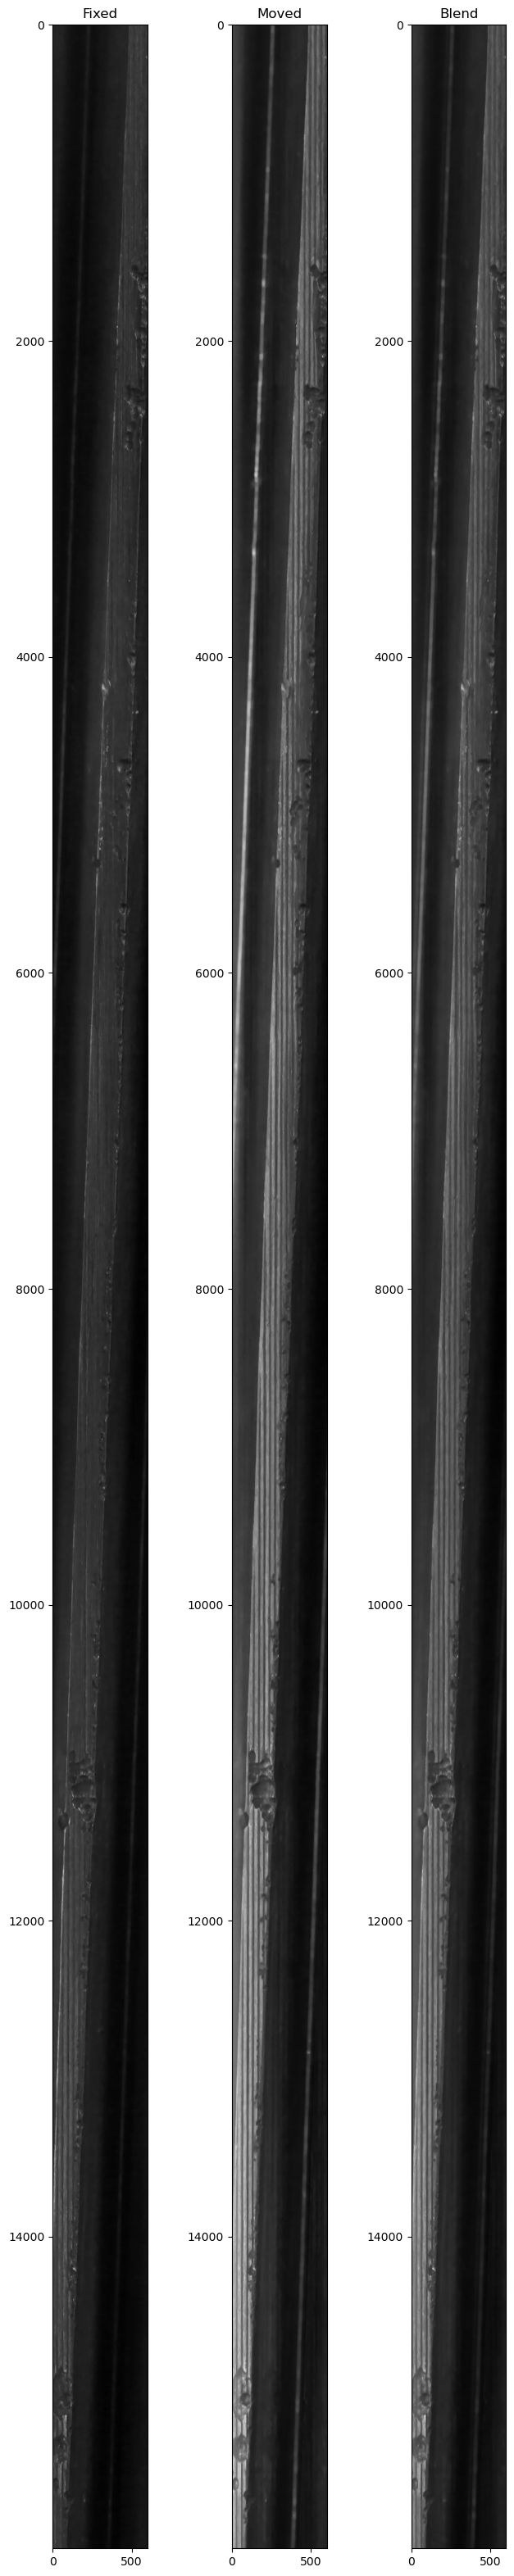

In [43]:
show_images(imgA, imgB, seed_position, s1.x)

In [47]:
first_frame = physics["first_frame"]
scan_shift = physics["scan_shift"]

scan_shifts.append(scan_shift)
rolls.append(roll)
seed_position = np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] + roll]]).astype(int)
imgA = rows_images[3]
imgB = rows_images[2]
s2 = minimize(to_minimize, x0=np.array([0, 0]), method='Powell', bounds=[(-15, +15),(-30, 30)], options={'xtol': 1e-2, 'ftol': 1e-2, 'disp': True})

Optimization terminated successfully.
         Current function value: -0.658494
         Iterations: 2
         Function evaluations: 87


In [48]:
s2

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.6584942017092856
       x: [ 6.371e+00  7.079e+00]
     nit: 2
   direc: [[ 0.000e+00  1.000e+00]
           [-1.063e-01 -1.315e-01]]
    nfev: 87

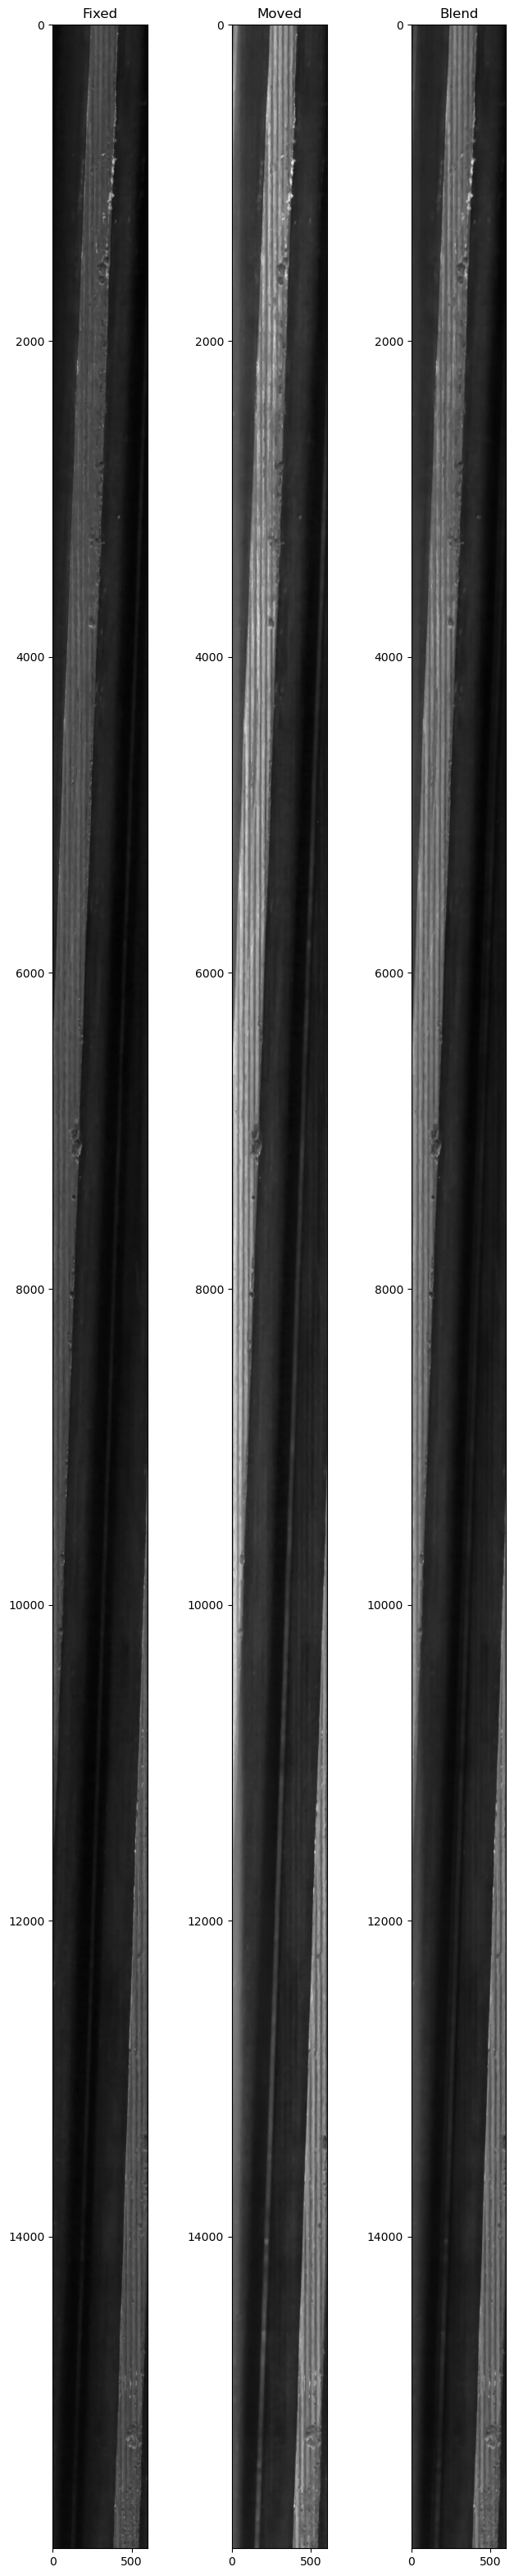

In [49]:
show_images(imgA, imgB, seed_position, s2.x)

In [50]:
scan_shifts.append(scan_shift)
rolls.append(roll)

imgA = rows_images[2]
imgB = rows_images[1]
s3 = minimize(to_minimize, x0=np.array([0, 0]), method='Powell', bounds=[(-15, +15),(-30, 30)], options={'xtol': 1e-2, 'ftol': 1e-2, 'disp': True})

Optimization terminated successfully.
         Current function value: -0.593629
         Iterations: 2
         Function evaluations: 84


In [51]:
s3

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.5936291837278362
       x: [ 8.506e+00 -2.532e+00]
     nit: 2
   direc: [[ 0.000e+00  1.000e+00]
           [ 2.333e-02 -4.101e-03]]
    nfev: 84

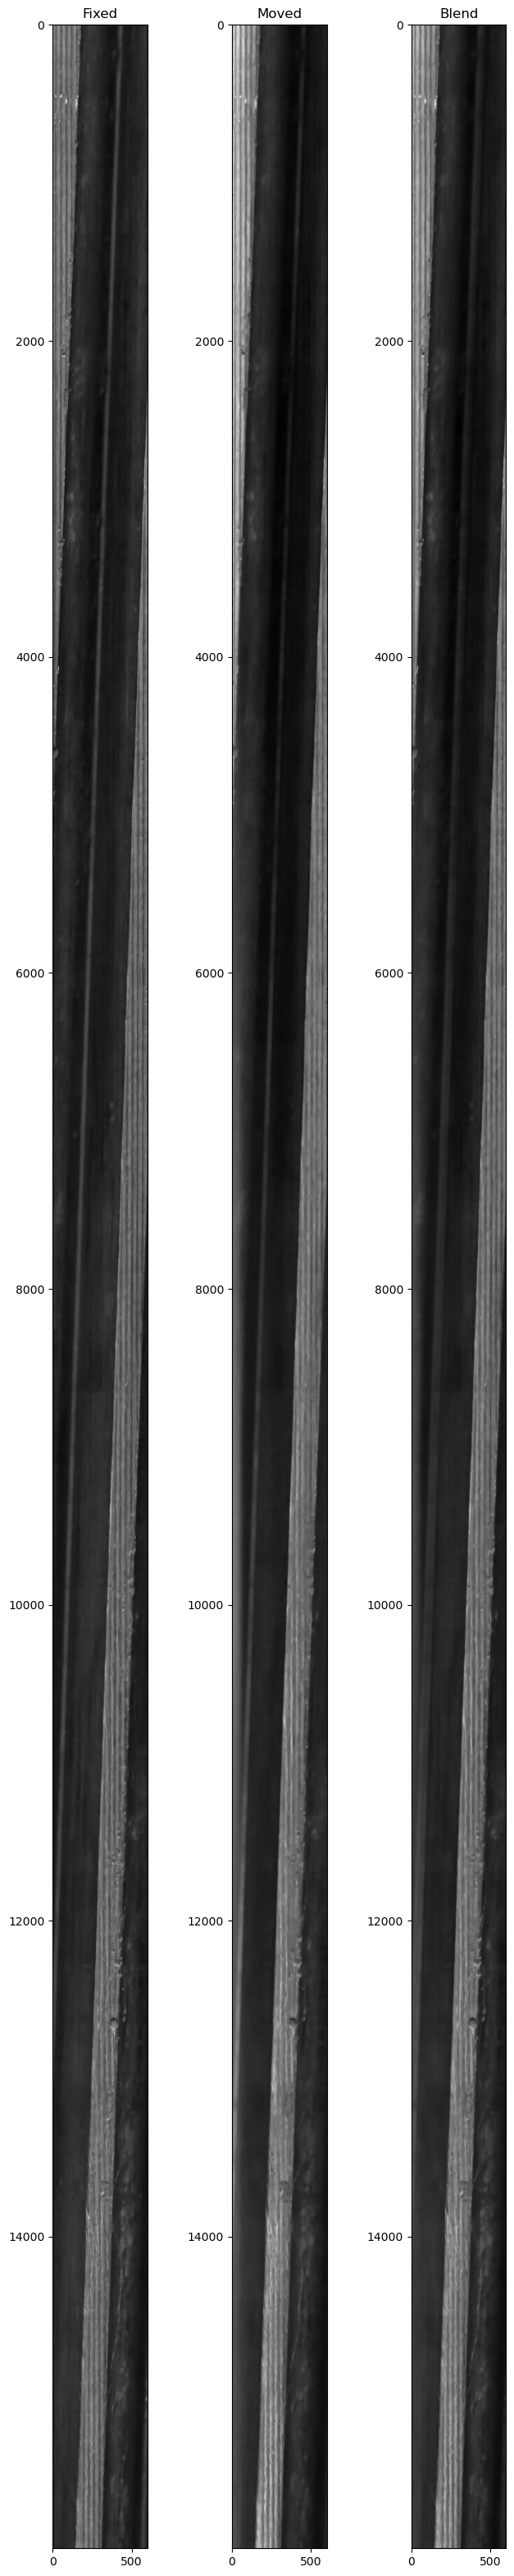

In [52]:
show_images(imgA, imgB, seed_position, s3.x)

In [54]:
scan_shifts.append(scan_shift)
rolls.append(roll)
seed_position = np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] + roll]]).astype(int)
imgA = rows_images[1]
imgB = rows_images[0]
s4 = minimize(to_minimize, x0=np.array([0, 0]), method='Powell', bounds=[(-15, +15),(-30, 30)], options={'xtol': 1e-2, 'ftol': 1e-2, 'disp': True})

Optimization terminated successfully.
         Current function value: -0.634336
         Iterations: 2
         Function evaluations: 81


In [55]:
s4

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.6343360042401505
       x: [ 1.337e+01  5.516e+00]
     nit: 2
   direc: [[ 0.000e+00  1.000e+00]
           [-1.257e+00 -2.364e-01]]
    nfev: 81

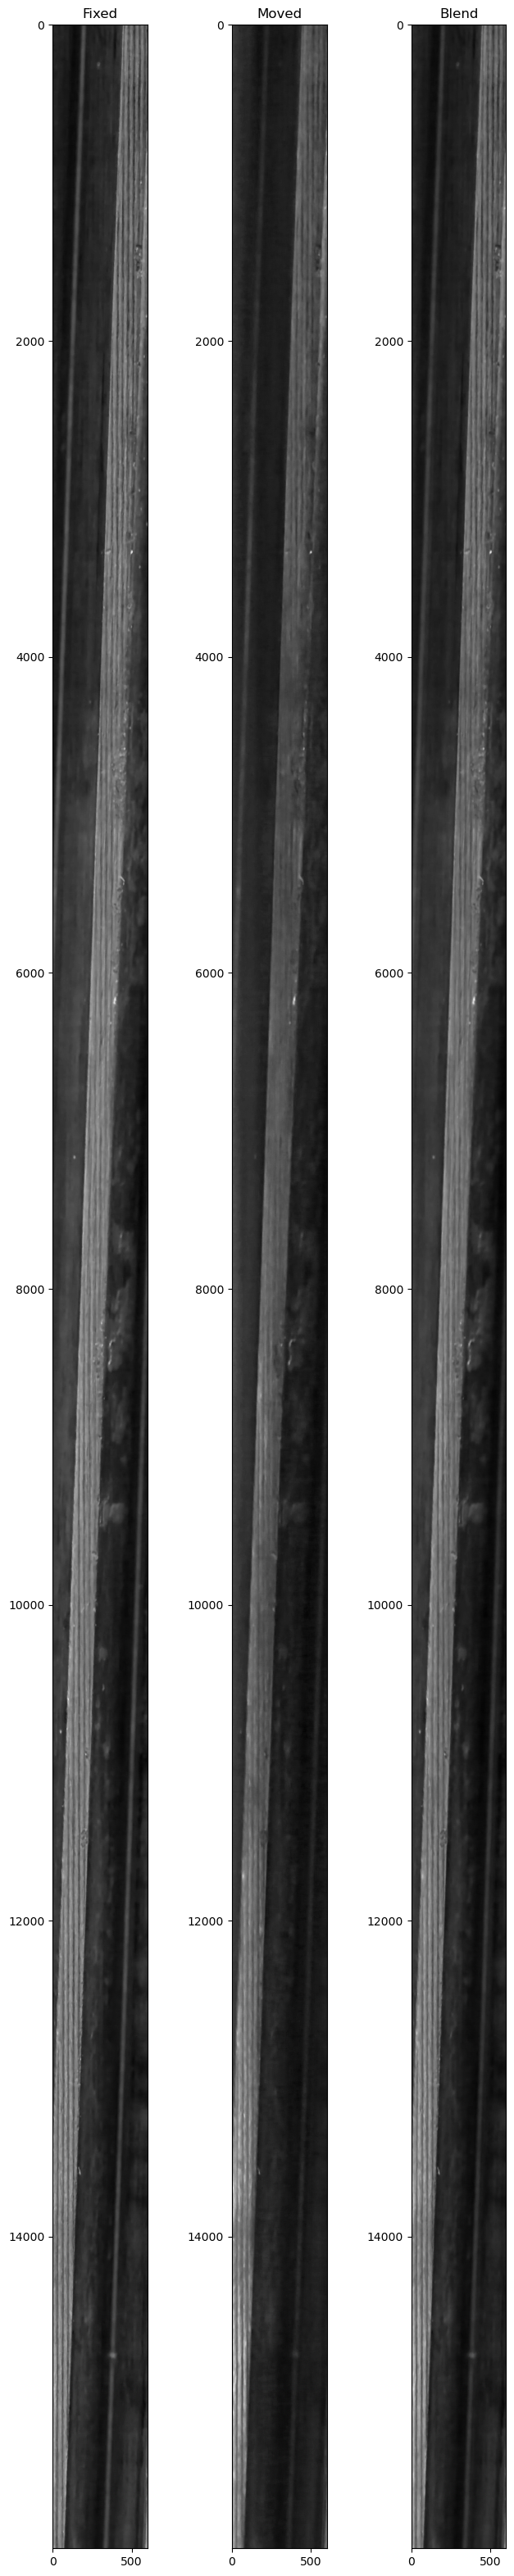

In [56]:
show_images(imgA, imgB, seed_position, s4.x)

In [ ]:
[[first_frame[0] - 4 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 4 * roll],
 [first_frame[0] - 5 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 5 * roll]]

In [ ]:
seed_position = np.array([[first_frame[0] - 4 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 4 * roll],
                          [first_frame[0] - 5 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 5 * roll]]).astype(int)
imgA = rows_images[4]
imgB = rows_images[5]
s5 = minimize(to_minimize, x0=[0, 0], method='Powell', bounds=[(-10, 10),(-10, 40)])

In [ ]:
s5

In [ ]:
show_images(imgA, imgB, seed_position, s5.x)

In [ ]:
[[first_frame[0] - 5 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 5 * roll],
 [first_frame[0] - 6 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 6 * roll]]

In [ ]:
seed_position = np.array([[first_frame[0] - 5 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 5 * roll],
                          [first_frame[0] - 6 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 6 * roll]]).astype(int)
imgA = rows_images[5]
imgB = rows_images[6]
s6 = minimize(to_minimize, x0=[0, 0], method='Powell', bounds=[(-10, 10),(-10, 40)])

In [ ]:
s6

In [ ]:
show_images(imgA, imgB, seed_position, s6.x)

In [167]:
shift_fixes = np.array([s1.x, s2.x, s3.x])

## Merge

- sesbírat posun per row
- aggregovats `sn.x`
- provést roll každé otočky + interpolaci
- vyrobit váhovou matici pro překryv
- vynásobit / flatnout

In [ ]:
shift_seed = []
shift_seed.append(np.array([first_frame, [first_frame[0] - scan_shifts[0], first_frame[1] + rolls[0]]]).astype(int))
shift_seed.append(np.array([first_frame, [first_frame[0] - scan_shifts[1], first_frame[1] + rolls[1]]]).astype(int))
shift_seed.append(np.array([first_frame, [first_frame[0] - scan_shifts[2], first_frame[1] + rolls[2]]]).astype(int))

In [ ]:
per_row_shift = np.array([seed[0, :] - seed[1, :] - fix for seed, fix in zip(shift_seed, shift_fixes)])

In [ ]:
shift_seed

In [ ]:
per_row_shift

In [ ]:
def real_roll(array, shift, axis=0):    
    double_image = np.concatenate([array, array], axis=1)
    interp = RegularGridInterpolator(
        (np.arange(double_image.shape[0]), np.arange(double_image.shape[1])), 
        double_image
    )
    if shift > 0:
        y = np.arange(shift, shift + array.shape[1] - 0.5, 1)
    else:
        y = np.arange(shift + array.shape[1], 2 * array.shape[1] + shift - 0.5, 1)    
    x = np.arange(array.shape[0])    
    xg, yg = np.meshgrid(x, y)    
    return interp((xg, yg)).T

In [ ]:
rows_images[1][:,:12]

In [ ]:
# Test of the real roll function
plt.figure(figsize=(20,6))
ax = plt.subplot(211)
ax.imshow(real_roll(rows_images[1], per_row_shift[0,1]), cmap="gray")
ax.set_title("Rolled")
ax = plt.subplot(212)
ax.imshow(rows_images[1], cmap="gray")
ax.set_title("Original row 1")
plt.show()

In [ ]:
rows_images[0].shape

In [2]:
rolled = []
# Roll all rows as required and plot them
plt.figure(figsize=(20,20))
ax = plt.subplot(7, 1, 1)
ax.imshow(rows_images[0], cmap="gray")
rolled.append(rows_images[0])
for en, row_shift in enumerate(np.cumsum(-per_row_shift[:,1])):
    ax = plt.subplot(7, 1, en+2)
    rolled.append(real_roll(rows_images[en + 1], row_shift % rows_images[en + 1].shape[1]))
    ax.imshow(rolled[-1], cmap="gray")
    ax.set_title(f"Row {en + 1}, shift: {row_shift % rows_images[en + 1].shape[1]}")
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# merge rows

In [3]:
to_grid = [rolled[0]]
real_shift = [0]
for image, shift in tqdm(zip(rolled[1:], np.cumsum(per_row_shift[:,0])), total=per_row_shift.shape[0]):
    interp = RegularGridInterpolator(
        (np.arange(image.shape[0]), np.arange(image.shape[1])), 
        image
    )
    x = np.arange(image.shape[0] - 1)
    y = np.arange(image.shape[1])
    xg, yg = np.meshgrid(x,y)
    to_grid.append(interp((xg, yg)).T)
    real_shift.append(int(shift // 1))


IndexError: list index out of range

In [4]:
out_height = rolled[0].shape[0] + np.max(real_shift)

IndexError: list index out of range

In [5]:
full_image = np.zeros((out_height, rolled[0].shape[1], len(rolled)))
for en, (image, r_shift) in enumerate(zip(to_grid, real_shift)):
    full_image[r_shift: r_shift + image.shape[0], :, en] = image

NameError: name 'np' is not defined

In [6]:
blend_matrix = np.zeros((out_height, to_grid[0].shape[1], len(to_grid)))

blend_matrix[:real_shift[1], :, 0] += 1
lin_blend = np.dot(np.arange(0, 1, 1/(to_grid[0].shape[0] - real_shift[1])).reshape(-1, 1), 
                   np.ones((to_grid[0].shape[1],1)).T)
blend_matrix[real_shift[1]: to_grid[0].shape[0], :, 0] += np.flipud(lin_blend)
blend_matrix[real_shift[1]: to_grid[0].shape[0], :, 1] += lin_blend

for en, (image, r_shift) in enumerate(list(zip(to_grid, real_shift))[:-2]):
    blend_matrix[real_shift[en] + to_grid[en].shape[0]: real_shift[en + 2], :, en + 1] += 1
    lin_blend = np.dot(np.arange(0, 1, 1/(to_grid[en + 1].shape[0] + real_shift[en + 1] - real_shift[en + 2])).reshape(-1, 1), 
                       np.ones((to_grid[en + 1].shape[1],1)).T)
    blend_matrix[real_shift[en + 2]: to_grid[en + 1].shape[0] + real_shift[en + 1], :, en + 1] += np.flipud(lin_blend)
    blend_matrix[real_shift[en + 2]: to_grid[en + 1].shape[0] + real_shift[en + 1], :, en + 2] += lin_blend

blend_matrix[to_grid[en + 1].shape[0] + real_shift[en + 1]:, :, -1] += 1

NameError: name 'np' is not defined

In [7]:
blended_full_image = np.sum(full_image * blend_matrix, axis=2) / np.sum(blend_matrix, axis=2)

NameError: name 'np' is not defined

## Conclusion - Image READY

In [8]:
iio.imwrite(os.path.join(SRC, videos[-2]).replace(".MP4", "-oio-100.png"), blended_full_image.astype(np.uint8))

NameError: name 'iio' is not defined

# Rotate to diff

In [9]:
edges = cv2.Canny(blended_full_image.astype(np.uint8),80,200)

NameError: name 'cv2' is not defined

In [10]:
plt.figure(figsize=(15,8))
plt.imshow(edges, cmap="gray")
plt.show()

NameError: name 'plt' is not defined

In [11]:
lines = cv2.HoughLines(edges, 10, np.pi/1800, 1, min_theta=4/5 * np.pi, max_theta=np.pi)


NameError: name 'cv2' is not defined

In [12]:
plt.plot(lines[:,0,1])
plt.show()

NameError: name 'plt' is not defined

### Odbočka - copak je v GPMF datech

In [13]:
import gpmf
from scipy.ndimage import gaussian_filter1d as gaussian
from scipy.signal import butter, sosfilt

ModuleNotFoundError: No module named 'gpmf'

In [14]:
gpmf_stream = gpmf.io.extract_gpmf_stream(os.path.join(SRC, videos[0]))

NameError: name 'gpmf' is not defined

In [15]:
stream_content = []
for s in gpmf.parse.filter_klv(gpmf_stream, "GYRO"):
    content = []
    is_gyro = False
    for elt in s.value:
        content.append(elt)
        
    stream_content.append(content)

NameError: name 'gpmf' is not defined

In [16]:
len(stream_content) * 207

0

In [17]:
len(stream_content[0])

IndexError: list index out of range

In [18]:
plt.figure(figsize=(15,5))
ax=plt.subplot(111)
x = gaussian([np.mean([x for x, _, _ in content]) for content in stream_content], 1)
ax.plot(x - np.mean(x), label="horizontal")
y = gaussian([np.mean([x for _, x, _ in content]) for content in stream_content], 1)
ax.plot(y - np.mean(y), label="lens axis")
z = gaussian([np.mean([x for _, _, x in content]) for content in stream_content], 1)
ax.plot(z - np.mean(z), label="vertical")
plt.ylabel("rad/s")
plt.xlabel("video time (x)")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [19]:
from pykalman import KalmanFilter

ModuleNotFoundError: No module named 'pykalman'

In [20]:
kf = KalmanFilter(n_dim_obs=1, em_vars=['transition_covariance', 'observation_covariance', 'initial_state_mean'])

NameError: name 'KalmanFilter' is not defined

In [21]:
plt.plot(np.arange(0, len(y), 10), kf.em(y, n_iter=10).smooth(y[::10])[0].reshape(-1))
plt.plot(buttap(y))
plt.show()

NameError: name 'plt' is not defined

In [22]:
sos = butter(1, 60, 'hp', fs=1000, output='sos')
filtered = sosfilt(sos, y)

NameError: name 'butter' is not defined

In [23]:
plt.plot(filtered)
plt.plot(y)
plt.show()

NameError: name 'plt' is not defined